In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from PIL import Image
import os
import cv2
from keras import preprocessing
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from skimage import exposure

In [2]:
trainingDataHEM = 'C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/trainingDataAUG_HEM'
trainingDataHEM1 = 'C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/trainingDataHEM'
trainingDataALL = 'C:/Users/v4run/OneDrive/Desktop/Datasets/C-NMC_Leukemia/trainingDataALL'

In [3]:
def get_imlist(path):
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.bmp')]

In [4]:
img_listHem = []
load_path = get_imlist(trainingDataHEM)
for i in load_path:
    image_array = np.array(Image.open(i))
    resized = exposure.equalize_adapthist(image_array,clip_limit=0.15,nbins=256)

    img_listHem.append(resized)

In [5]:
len(img_listHem)

2517

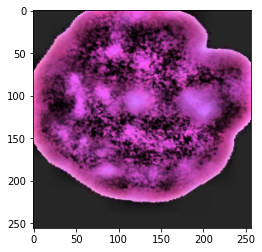

In [6]:
imshow(img_listHem[0])

In [7]:
load_path = get_imlist(trainingDataHEM1)
for i in load_path:
    image_array = np.array(Image.open(i))
    resized = exposure.equalize_adapthist(image_array,clip_limit=0.15,nbins=256)

    img_listHem.append(resized)

In [8]:
len(img_listHem)

4810

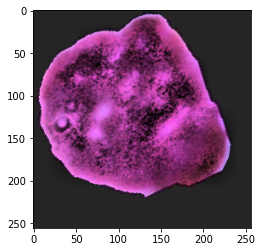

In [9]:
imshow(img_listHem[200])

In [10]:
img_listAll = []
load_path = get_imlist(trainingDataALL)
for i in load_path:
    image_array = np.array(Image.open(i))
    resized = exposure.equalize_adapthist(image_array,clip_limit=0.15,nbins=256)

    img_listAll.append(resized)

In [12]:
len(img_listAll)

4815

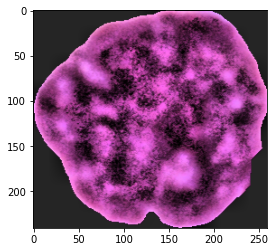

In [13]:
imshow(img_listAll[200])

In [14]:
def imageResize(img,size):
    image_resizing = cv2.resize(np.array(img), (size, size), interpolation=cv2.INTER_LANCZOS4)
    return image_resizing

In [15]:
resized_Hem = []
for index, img in enumerate(img_listHem):
    img = imageResize(img,256)
    
    resized_Hem.append(img)

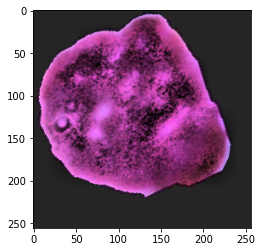

In [16]:
imshow(resized_Hem[200])

In [17]:
len(resized_Hem)

4810

In [19]:
data_Hem = np.array(resized_Hem)

In [20]:
resized_ALL = []
for index, img in enumerate(img_listAll):
    img = imageResize(img,256)
    resized_ALL.append(img)

KeyboardInterrupt: 

In [ ]:
data_All = np.array(resized_ALL)